In [112]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import lmfit as lf

# plt.style.use(
#     "https://raw.githubusercontent.com/sheamusfitz/mpl-styles/main/smallfigs.mplstyle")

import acorcor
from autocor import autocor

This little walkthrough is going to have the following stuff:

- I'll generate some random exponentailly correlated data
- get their autocorrelation functions
- fit them to the naive and the bias-corrected autocorrelation forms

# generate data

In [113]:
ntries = 100
sample_len = 50_000
noise = np.random.normal(0, 1, size=(ntries, sample_len))
tau = 10000

`the_sig` is the generated data series with the mean subtracted off. 

`with_mean` does **not** have the mean subtracted.

In [114]:
the_sig = np.zeros_like(noise)
with_mean = np.zeros_like(noise)
f = np.exp(-1/tau)
the_sig[:, 0] = noise[:, 0]
with_mean[:, 0] = noise[:, 0]
for i in range(ntries):
    print(i, end='\t')
    for j in range(1, sample_len):
        the_sig[i, j] = f * the_sig[i, j-1] + (1-f**2)**(1/2)*noise[i, j]
    with_mean[i, :] = np.copy(the_sig[i, :])
    the_sig[i, :] -= np.mean(the_sig[i, :])

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	

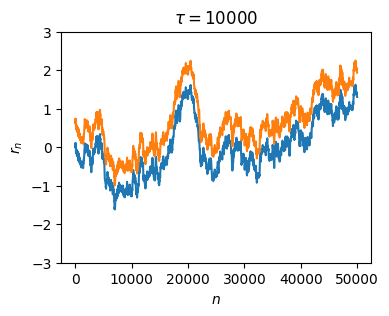

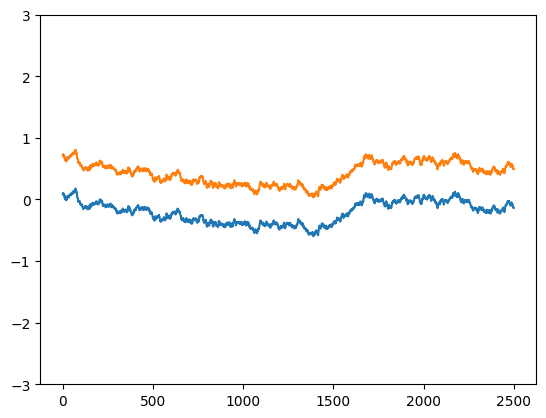

In [115]:
plt.figure(figsize=(4,3))
plt.plot(np.arange(0, sample_len, 20), the_sig[0, ::20])
plt.plot(np.arange(0, sample_len, 20), with_mean[0, ::20])
plt.ylim(-3,3)
plt.title(f'$\\tau = ${tau}')
plt.ylabel('$r_n$')
plt.xlabel('$n$')
plt.show()


plt.plot(the_sig[0, :sample_len//20])
plt.plot(with_mean[0, :sample_len//20])
plt.ylim(-3,3)
plt.show()

In [116]:
acor = np.zeros_like(the_sig)
for i in range(ntries):
    acor[i] = autocor(the_sig[i])
lags = np.arange(sample_len)
theoretical = np.exp(-np.abs(lags)/tau)

meanacor = np.zeros_like(the_sig)
for i in range(ntries):
    meanacor[i] = autocor(with_mean[i], demean=False)

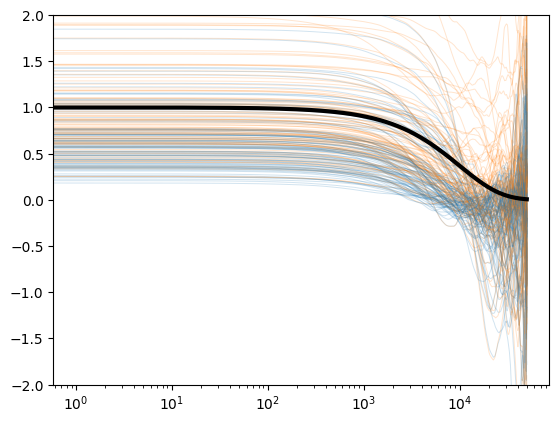

In [117]:
for i in range(1,ntries):
    plt.plot(lags, acor[i], 'C0', alpha = 0.2, lw=0.7)
    plt.plot(lags, meanacor[i], 'C1', alpha = 0.2, lw=0.7)
plt.plot(lags, theoretical, 'k', lw=3, label = '$e^{-t/τ}$')
# plt.yscale('symlog', linthresh=0.8)
plt.ylim(-2,2)
plt.xscale('log')

0
1
2
3
plotting


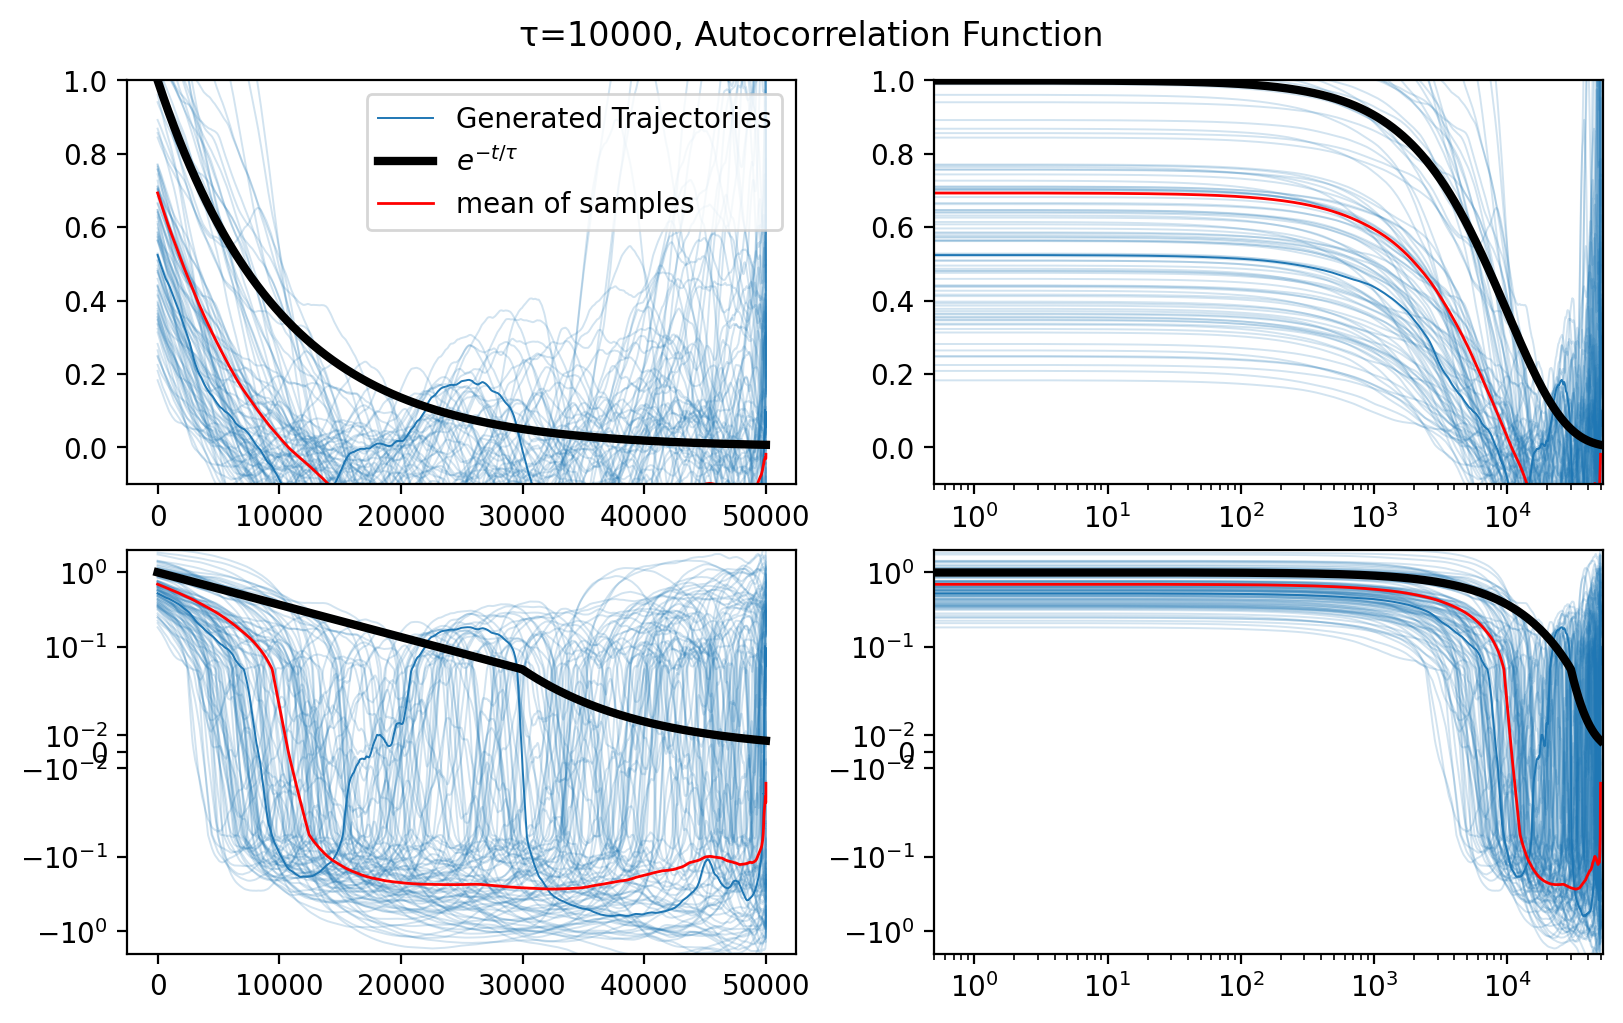

In [118]:
plt.subplots(2, 2, figsize=(8,5), dpi=200, constrained_layout=True)
for s in range(4):
    print(s)
    plt.subplot(2, 2, s+1)
    plt.plot(lags, acor[0], 'C0', alpha = 1, lw=0.7, label = "Generated Trajectories")
    for i in range(1, ntries):
        plt.plot(lags, acor[i], 'C0', alpha = 0.2, lw=0.7)
    plt.plot(lags, theoretical, 'k', lw=3, label = '$e^{-t/τ}$')
    plt.ylim(-0.1, 1)
#     plt.xlim(0, 10000)
    if s%2:
        plt.xlim(left=0.5)
        plt.xscale('log')
    if s//2:
        plt.yscale('symlog', linthresh = 5e-2)
        plt.ylim(-2,2)
    plt.plot(lags, np.mean(acor, axis=0), 'r', lw=1, label = 'mean of samples')
    if s==0:
        plt.legend(loc='upper right')

print('plotting')
plt.suptitle(f'τ={tau:0.0f}, Autocorrelation Function')
plt.show()

# Naive fit

In [119]:
def expfit(t, a, b, c):
    return a*np.exp(-t/b) + c
expmodel = lf.Model(expfit, independent_vars='t')

In [120]:
mm = np.mean(acor, axis=0)
ss = np.std(acor, axis=0)/(len(acor)-1)**0.5

params = expmodel.make_params()

params.add('a', min = 0.001, max = 10)
params.add('b', min = 500, max = 15000)
params.add('c', min = -50, max = 50)

start = 50
stop = sample_len//10
nw = 200

pos = np.zeros((nw, 3))
pos[:, 0] = np.random.uniform(0.001, 10, nw)
pos[:, 1] = np.random.uniform(500, 15000, nw)
pos[:, 2] = np.random.uniform(-50, 50, nw)
result = expmodel.fit(
    mm[start:stop], params, t=np.arange(start,stop), method='emcee',
    fit_kws={'nwalkers': nw, 'pos': pos, 'burn': 200, 'steps': 2000},
    weights = ss[start:stop]**-1
)

100%|██████████████████████████████████████| 2000/2000 [00:17<00:00, 116.69it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [33.59153778 56.56916071 14.97500488]


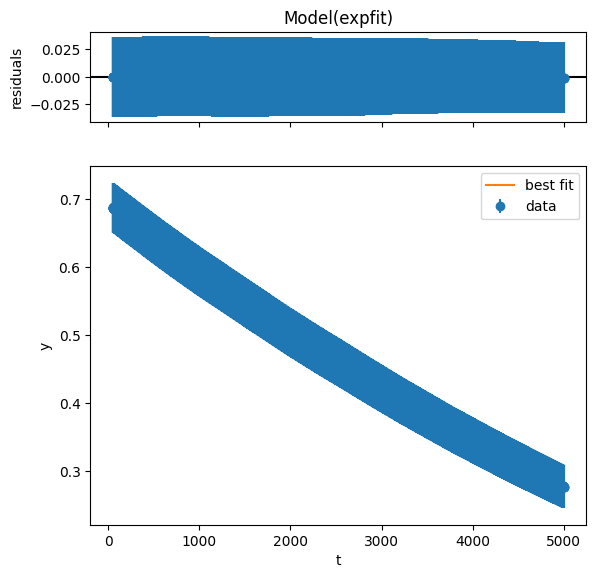

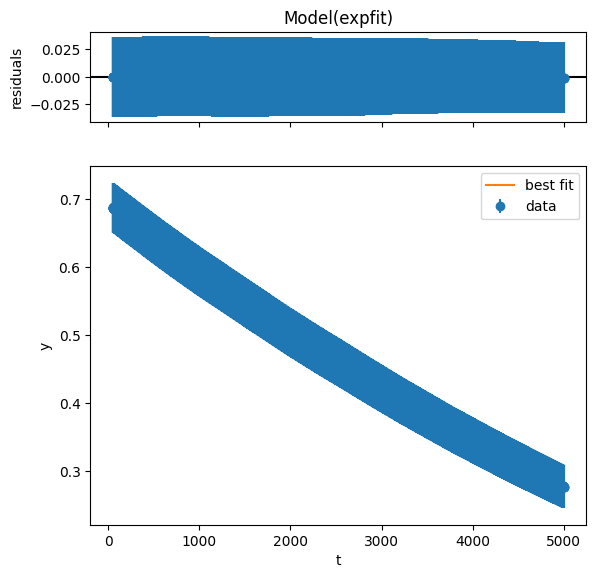

In [121]:
result.plot()

## looking at the "chains" (monte carlo trajectories) of the parameter walkers

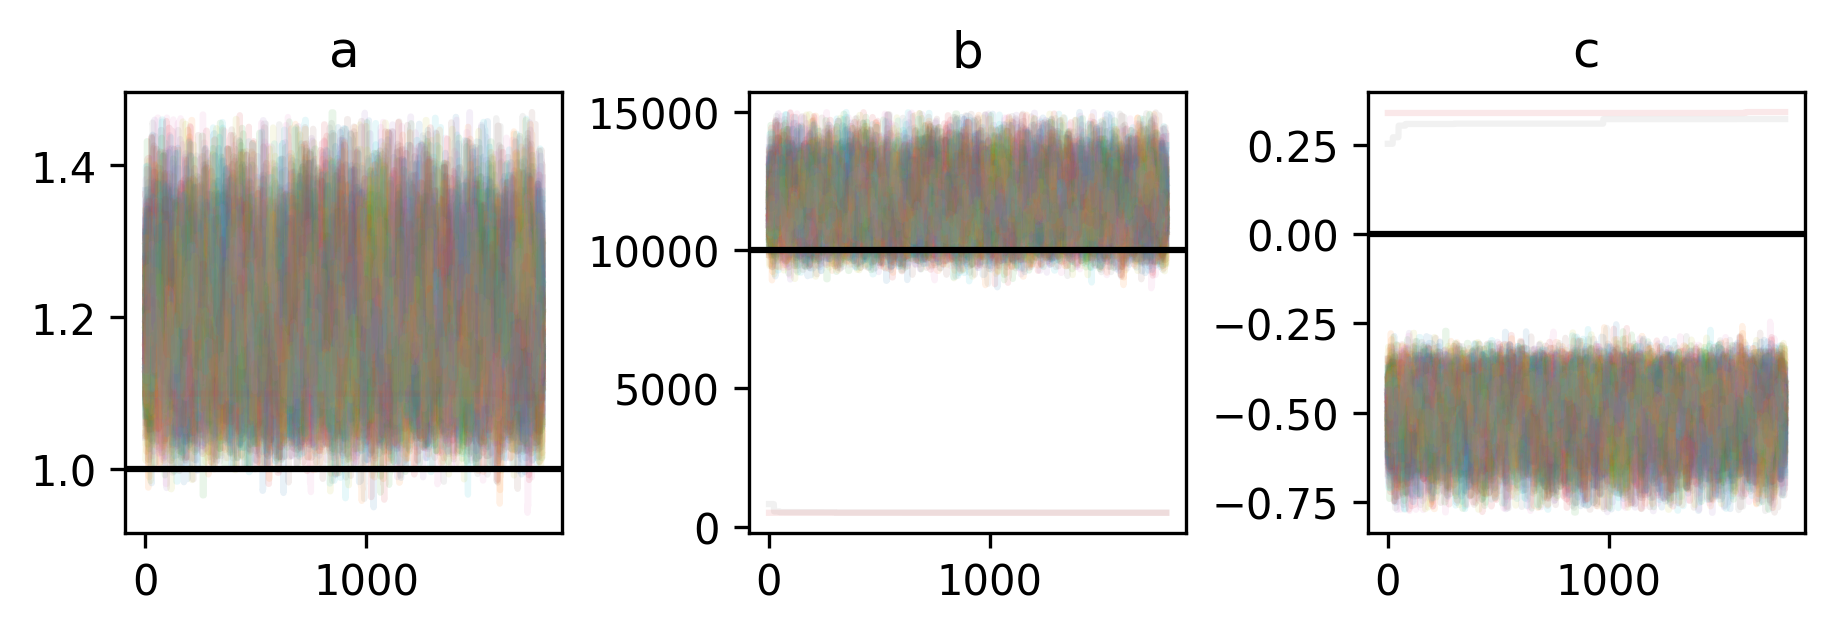

In [122]:
plt.subplots(1, 3, figsize=(6, 2), constrained_layout=True, dpi=300)
for sub in range(3):
    plt.subplot(1, 3, sub+1)
    plt.plot(result.chain[:, :, sub], alpha=0.1)
    plt.title(list(result.params)[sub])
plt.subplot(131)
plt.axhline(1, c='k')
plt.subplot(132)
plt.axhline(tau, c='k')
plt.subplot(133)
plt.axhline(0, c='k')

# Bias Corrected Fit

In [123]:
def cor_exp(t, a, b, c, n=sample_len):
    return c+acorcor.corrected_exp(t, b, n, a=a)
cexpmodel = lf.Model(cor_exp, independent_vars='t')

In [124]:
mm = np.mean(acor, axis=0)
ss = np.std(acor, axis=0)/(len(acor)-1)**0.5

params = cexpmodel.make_params()

params.add('a', min = 0.001, max = 4)
params.add('b', min = 500, max = 15000)
params.add('c', min = -50, max = 50, value=0, vary=False)
params.add('n', value=sample_len, vary=False)

start = 50
stop = sample_len//2
nw = 200

pos = np.zeros((nw, 2))
pos[:, 0] = np.random.uniform(0.001, 4, nw)
pos[:, 1] = np.random.uniform(1000, 15000, nw)
# pos[:, 2] = np.random.uniform(-50, 50, nw)
c_result = cexpmodel.fit(
    mm[start:stop], params, t=np.arange(start,stop), method='emcee',
    fit_kws={'nwalkers': nw, 'pos': pos, 'burn': 200, 'steps': 2000},
    weights = ss[start:stop]**-1
)

100%|███████████████████████████████████████| 2000/2000 [01:58<00:00, 16.92it/s]


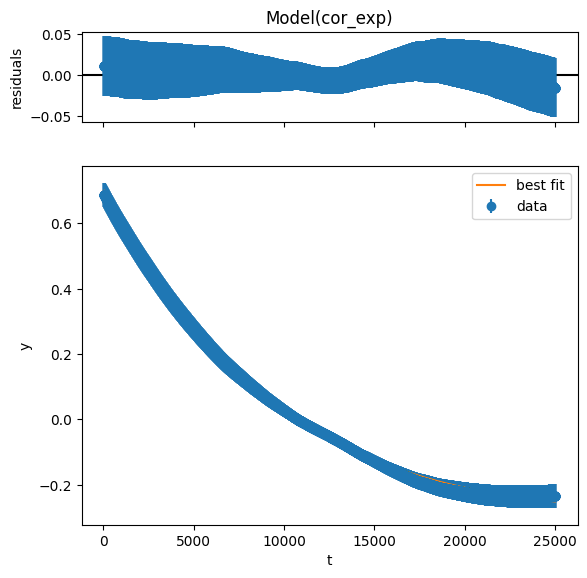

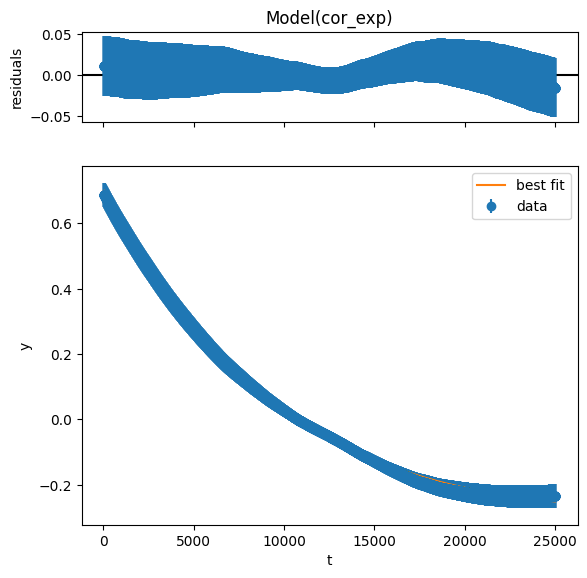

In [125]:
c_result.plot()

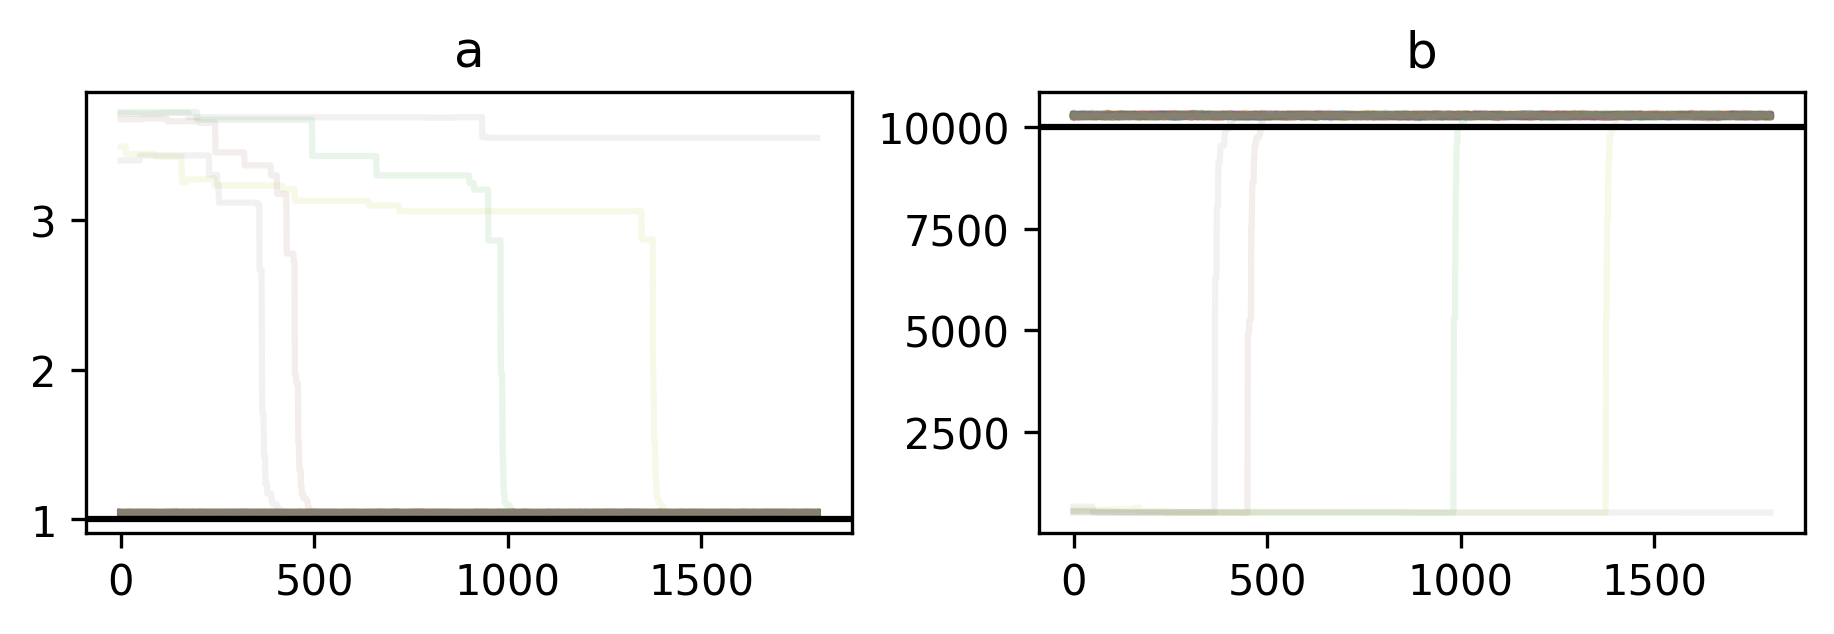

In [126]:
plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True, dpi=300)
for sub in range(2):
    plt.subplot(1, 2, sub+1)
    plt.plot(c_result.chain[:, :, sub], alpha=0.1)
    plt.title(list(c_result.params)[sub])
plt.subplot(121)
plt.axhline(1, c='k')
plt.subplot(122)
plt.axhline(tau, c='k')

In [127]:
print(f"{result.params['b'].value:0.1f} ± {result.params['b'].stderr:0.1f}")
print(f"{c_result.params['b'].value:0.1f} ± {c_result.params['b'].stderr:0.1f}")

11514.2 ± 885.6
10294.6 ± 19.6


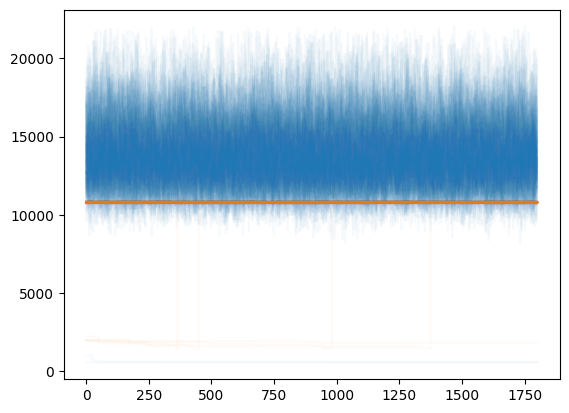

In [130]:
plt.plot(result.chain[:, :, 0]*result.chain[:, :, 1], alpha=0.03, c='C0')
plt.plot(c_result.chain[:, :, 0]*c_result.chain[:, :, 1], alpha=0.03, c='C1')
plt.show()